In [ ]:
import os
os.getcwd()
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize 
from scipy.stats import norm
import math
from scipy.stats import poisson
from scipy.stats import nbinom
from scipy.special import gamma
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy import stats 
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.stats import poisson
from scipy.stats import nbinom
from scipy.special import gamma
from scipy.special import factorial

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Reading the excel file
file= "/content/hw3_data-1.xlsx"
data = pd.read_excel(file,sheet_name='Q1',skiprows=3,)


In [ ]:
data.head(5)

,ads clicked,Gender (M=1),Age (25-34)
0,0,0,0
1,6,0,0
2,8,0,0
3,9,0,0
4,9,0,1


In [ ]:
#Renaming the columns
data.rename(columns={'Gender (M=1)':'gender_male','Age (25-34)':'Age_15_24'},inplace=True)

In [ ]:
data['no_of_users']=0

In [ ]:
#Aggregating the data
data_sorted=data.groupby('ads clicked').agg({'no_of_users':'count','gender_male':'sum','Age_15_24':'sum'}).reset_index()
data_sorted.head(5)

,ads clicked,no_of_users,gender_male,Age_15_24
0,0,1,0,0
1,6,1,0,0
2,8,1,0,0
3,9,4,0,3
4,10,7,3,3


### Poisson Estimate

In [ ]:
#Applying Poisson distribution
def MLE_Pois(param):
    lamda=param
    #This code has been taken from Professor's shared code  
    #Either you can use poisson PDF or use poisson by Python

    L =np.log(poisson.pmf(data_sorted['ads clicked'],lamda))*data_sorted.no_of_users
    LL=-sum(L)

    return LL
        

In [ ]:
mle_model = minimize(MLE_Pois, x0=0.2, method='SLSQP',options={'disp': True})

mle_model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 385.0886593819885
            Iterations: 12
            Function evaluations: 43
            Gradient evaluations: 12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


     fun: 385.0886593819885
     jac: array([-4.57763672e-05])
 message: 'Optimization terminated successfully.'
    nfev: 43
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([19.34999319])

## The Poisson estimate of lambda is 19.34. This means that the average expected number of clicks is 19.34

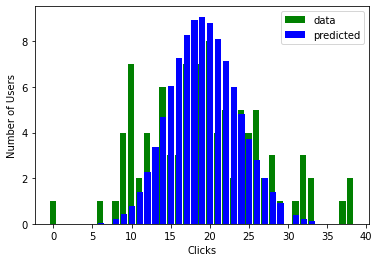

In [ ]:
#Plotting the predictions
lamda=mle_model.x[0]

plt.bar(data_sorted['ads clicked']-0.05,data_sorted['no_of_users'],color="green",label='data')
plt.bar(data_sorted['ads clicked']+0.05,poisson.pmf(data_sorted['ads clicked'],lamda)*len(data),color="blue",label='predicted')
plt.xlabel('Clicks')
plt.ylabel('Number of Users')

plt.legend()

## From the above histogram we can see that the predictions from the Poisson are not very good.

### NBD Estimate

In [ ]:
def MLE_NBD(param):
    alpha=param[0]
    r=param[1]
     #This code has been taken from Professor's shared code
    yy=data_sorted['ads clicked']
    
    g=gamma(r+yy)/(gamma(r)*factorial(yy))
    
    e=((alpha/(alpha+1))**r)*((1/(1+alpha))**yy)
    
    L=np.log(g*e)*data_sorted['no_of_users']
    LL=-sum(L)

    return LL


In [ ]:
mle_model = minimize(MLE_NBD, [1,1], method='SLSQP',options={'disp': True},)
mle_model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 343.9092168319349
            Iterations: 17
            Function evaluations: 75
            Gradient evaluations: 17


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


     fun: 343.9092168319349
     jac: array([ 0.01412964, -0.00050735])
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([0.4929565 , 9.53860454])

### The parameters estimated from NBD are 'r' and 'alpha'.
### r=9.53, alpha=0.49

### The expected number of clicks= r/alpha = 9.53 / 0.49=19.448

In [ ]:
#Estimating predictions using the estimated paramters
alpha=mle_model.x[0]
r=mle_model.x[1]
yy=data_sorted['ads clicked']

g=gamma(r+yy)/(gamma(r)*factorial(yy))

e= ((alpha/(alpha+1))**r)*((1/(1+alpha))**yy)

P=gamma(r+data_sorted['ads clicked'])/(gamma(r)*factorial(data_sorted['ads clicked'])) \
    *(alpha/(1+alpha))**r*(1/(1+alpha))**data_sorted['ads clicked']



### The predictions from NBD look more accurate than those of Poisson.

In [ ]:
#Calculating the number of females 
data_sorted['gender_female']=data_sorted['no_of_users']-data_sorted['gender_male']
data_sorted.head()

,ads clicked,no_of_users,gender_male,Age_15_24,gender_female
0,0,1,0,0,1
1,6,1,0,0,1
2,8,1,0,0,1
3,9,4,0,3,4
4,10,7,3,3,4


### Incorporating gender and age information as covariates

### We use the sigmoid function to incorporate the covariates using

### lamda=lamda_0 * np.exp(beta_1 * data.gender_male+beta_2 * data.Age_15_24)

In [ ]:
def MLE_Poisson_cov(param):
    beta_1=param[0]
    beta_2=param[1]
    lamda_0=param[2]
    #This code has been taken from Professor's shared code
    #Incorporating covariates
    lamda=lamda_0*np.exp(beta_1*data.gender_male+beta_2*data.Age_15_24)
    L=np.log(poisson.pmf(data['ads clicked'],lamda))
    
    LL = -sum(L)
    
    return LL

In [ ]:

mle_model = minimize(MLE_Poisson_cov, [0.1,0.05,0.008], method='SLSQP',options={'disp': True})
mle_model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 354.81142812701336
            Iterations: 25
            Function evaluations: 141
            Gradient evaluations: 25


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_discrete_distns.py:604: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


     fun: 354.81142812701336
     jac: array([-0.00777054, -0.00703812, -0.00111389])
 message: 'Optimization terminated successfully.'
    nfev: 141
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([ 0.35818388,  0.02245554, 15.57888631])

### The estimated paramters are beta_1= 0.35, beta_2=0.022 and lamda_0=15.57.

In [ ]:
#Using the paramters to predict
beta_1=mle_model.x[0]
beta_2=mle_model.x[1]
lamda_0=mle_model.x[2]
data['lamda']=lamda_0*np.exp(beta_1*data.gender_male+beta_2*data.Age_15_24)

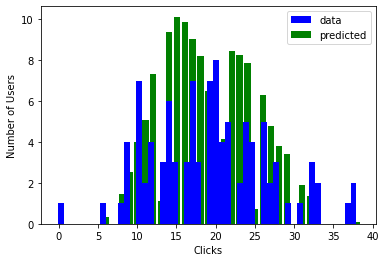

In [ ]:
#Plotting the predictions vs original
plt.bar(data['ads clicked']+0.05,poisson.pmf(data['ads clicked'],data['lamda'])*len(data),color="green",label='predicted')
plt.hist(data['ads clicked']-0.05,color="blue",label='data',bins = 50)
plt.xlabel('Clicks')
plt.ylabel('Number of Users')

plt.legend()

In [ ]:
#Calculating the expected number of clicks for different segments

beta_1=mle_model.x[0]
beta_2=mle_model.x[1]
lamda=mle_model.x[2]
data['expected_lambda']=lamda*np.exp(beta_1*data.gender_male+beta_2*data.Age_15_24)
segment_female=data.groupby(['gender_male']).agg({'expected_lambda':'mean'})
segment_female

,expected_lambda
gender_male,
0,15.744490
1,22.547023


### Expected number of clicks for users who are females =15.74

In [ ]:
segment_age=data.groupby(['Age_15_24']).agg({'expected_lambda':'mean'})
segment_age

,expected_lambda
Age_15_24,
0,18.999810
1,19.714142


### Expected number of clicks for users who are aged 15-24= 19.71